# __Stack Overflow public survey 2017__
## __How to break into the field?__



In [307]:
# loading modules
import pandas as pd
import numpy as np
import re
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick

from stack_functions import getChoices, convert2USD

In [178]:
# setting up display
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']= 8, 8
plt.rcParams['font.size']=8

## Load the dataset
___

In [179]:
# load data and data schema
df = pd.read_csv('../DataSets/StackOverflow/survey-results-public.csv')
df_sch = pd.read_csv('../DataSets/StackOverflow/survey-results-schema.csv')

## What kind of professional are represented in this dataset?
___

In [319]:
df_sch.query('Column == "Professional"')

,Column,Question
1,Professional,Which of the following best describes you?


In [320]:
md(f'>_There are "{df["Professional"].isna().sum()}" missing values in this category_')

>_There are "0" missing values in this category_

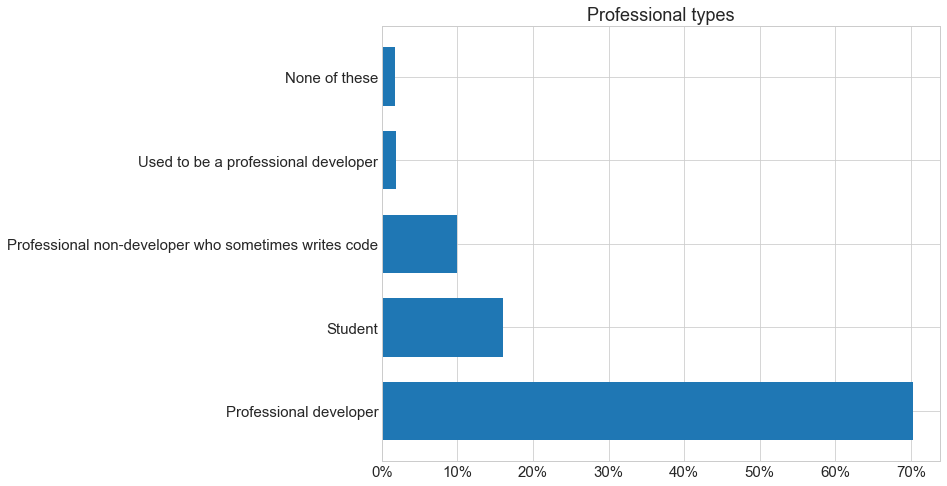

In [328]:
# shows count for each professional category
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=10,8

perc_pro = df['Professional'].value_counts(normalize=True)
ax = perc_pro.plot(kind='barh', title='Professional types', width=.7)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

> __for the rest of this analysis we will focus on the "Profesional developer" only__

In [183]:
# We are keeping only "Professional developer"
df_pro = df.query('Professional == "Professional developer"')

## What is the proportion of New Hires (<= 4 years)?
We will restrict our analysis to new hires to have a better image of good advices for breaking into the field
___

In [358]:
txt = df_sch.query('Column == "LastNewJob"')['Question'].tolist()[0]
md(f'__The Question read as:__<br/> _{txt}_')

__The Question read as:__<br/> _When was the last time that you took a job with a new employer?_

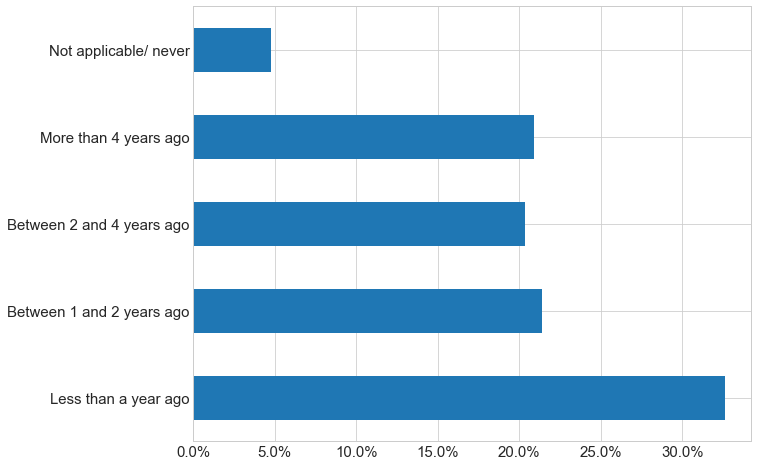

In [340]:
per_nhires = df_pro['LastNewJob'].value_counts(normalize=True).reindex(index = 
                                                                      [
                                                                          'Less than a year ago',
                                                                          'Between 1 and 2 years ago',
                                                                          'Between 2 and 4 years ago',
                                                                          'More than 4 years ago',
                                                                          'Not applicable/ never'
                                                                      ]
                                                                     )

ax_nhires = per_nhires.plot(kind='barh')
ax_nhires.xaxis.set_major_formatter(mtick.PercentFormatter(1))

In [341]:
df_nhires = df_pro.query('LastNewJob in ["Less than a year ago","Between 1 and 2 years ago","Between 2 and 4 years ago"]')

## Education Advices from "New Hires Professional"
What professionals think is the best way to enter the field?

---

> We are using the ```getChoices()``` function to extract all unique possible choices in ```'CousinEducation'``` -> we will obtain all observations where each unique choices were found


In [357]:
txt = df_sch.query('Column == "CousinEducation"')['Question'].values[0].replace('\n', '<br/>')
md(f'__The Question read as:__<br/> _{txt}_')

__The Question read as:__<br/> _Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?<br/>Let's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?<br/>Let's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Alice?_

In [360]:
dictEducAdv = getChoices(df_nhires['CousinEducation'])
# count values for each category of 'CousinEducation' 
AdvCount = {k: len(v) for k, v in dictEducAdv.items()}
AdvCount

{'Get a job as a QA tester': 1477,
 'Take online courses': 5859,
 'Contribute to open source': 2842,
 'Part-time/evening courses': 2853,
 'Participate in online coding competitions': 1310,
 'Buy books and work through the exercises': 4395,
 'Conferences/meet-ups': 2166,
 "Master's degree": 956,
 'Return to college': 1818,
 'Participate in hackathons': 1069,
 'Other': 932,
 'Bootcamp': 2096,
 'None of these': 179}

Text(0.5, 1.0, 'What would you most strongly recommend to your cousin?')

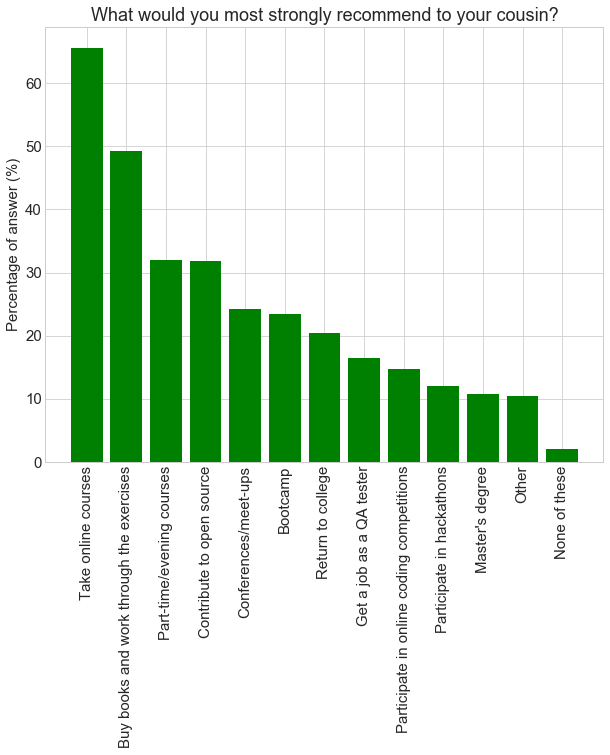

In [383]:
# first we reorder answers by count
mask = ~df_nhires['CousinEducation'].isna()
total_respondent = mask.sum()

AdvCount = dict(sorted(AdvCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_Adv = np.array(list(AdvCount.values()))/total_respondent # compute percentage over all participants

plt.bar(list(AdvCount.keys()), perc_Adv*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title('What would you most strongly recommend to your cousin?')

---
> __How to break into the field?__

In [414]:
pos_str = ['1st', '2nd', '3rd']
txt = ''
for pos in range(len(pos_str)):
    txt += (f'The {pos_str[pos]} most given advice is to _"{list(AdvCount.keys())[pos]}"_ with __{perc_Adv[pos]:.2%}__ of the votes.<br/>')

md(txt)

The 1st most given advice is to _"Take online courses"_ with __65.62%__ of the votes.<br/>The 2nd most given advice is to _"Buy books and work through the exercises"_ with __49.23%__ of the votes.<br/>The 3rd most given advice is to _"Part-time/evening courses"_ with __31.96%__ of the votes.<br/>

> About 66% of the recent hires advice to Take online classes to switch thier to a software developer

## __Job Satisfaction for Recent Hires by Education Advices__

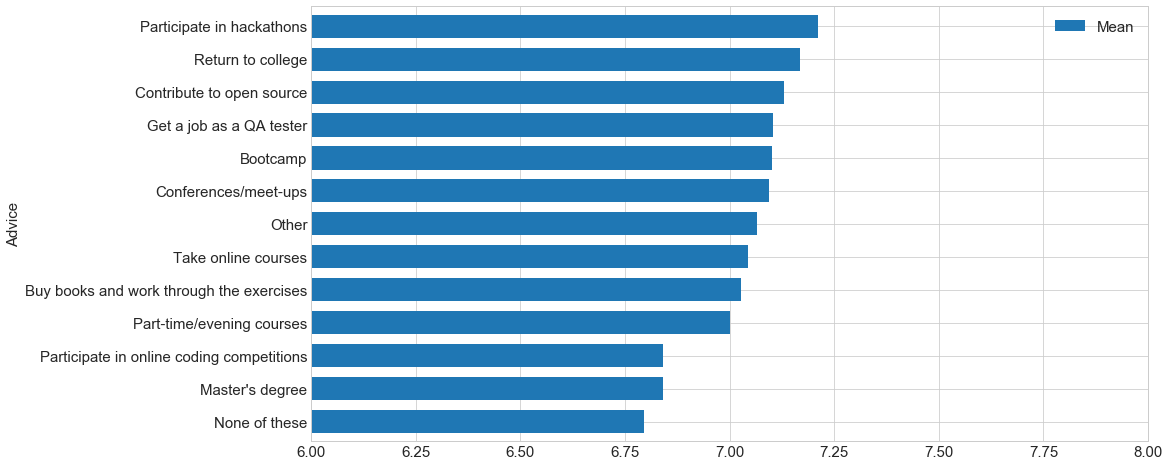

In [399]:
d = []
for adv, idx in dictEducAdv.items():
    n_data = df_nhires.reset_index().reindex(idx)['JobSatisfaction']
    d.append(
        {
            'Advice': adv,
            'Median': n_data.median(),
            'Mean':  n_data.mean()
        }
    )

plt.rcParams['figure.figsize']=15, 8
pd.DataFrame(d).sort_values(by='Mean').plot(kind='barh', x='Advice', y='Mean', width=0.7, xlim=(6,8))

> The satisfaction score are fairly high and similar between the recent hires choosing different strategy to switch carreer to become software developer. "Participate in hackathons" present slightly higher score of job satisfaction > 7.  
Both "Bootcamp" and "Online classes" present > 7 score of Job Satisfaction.

# __Comparing former Education/Training in Position, Salary and Job Satisfaction__

In order to use Salary as a dependent variable to assess the success of each category, we will need to filter observation with missing values and convert the currency to obtain a similar metric
___

## What is Salary for this population looks like?

1. First explore the different currency reported in the dataset

In [415]:
# filter dataset by removing all missing value in salary and missing Currency
df_nhires = df_nhires.dropna(subset=['Salary', 'Currency']).reset_index(drop=True)

In [416]:
df_nhires['Currency'].value_counts()

U.S. dollars ($)               2318
Euros (€)                      1636
British pounds sterling (£)     725
Indian rupees (?)               434
Canadian dollars (C$)           372
Polish zloty (zl)               190
Australian dollars (A$)         138
Brazilian reais (R$)            133
Swedish kroner (SEK)            108
Russian rubles (?)              108
Swiss francs                     73
Mexican pesos (MXN$)             56
South African rands (R)          51
Japanese yen (¥)                 32
Chinese yuan renminbi (¥)        31
Singapore dollars (S$)           15
Bitcoin (btc)                     3
Name: Currency, dtype: int64

2. Convert Salary to USD equivalent salary

In [417]:
# We are using our custom function ```convert2USB``` to change all currency if not USD.
df_nhires['SalaryConv_USD'] = df_nhires[['Salary', 'Currency']].apply(lambda x: convert2USD(x[1], np.round(x[0])),axis=1)

> checking for outliers salary

Text(0.5, 0, 'Survey answer among "Professional"')

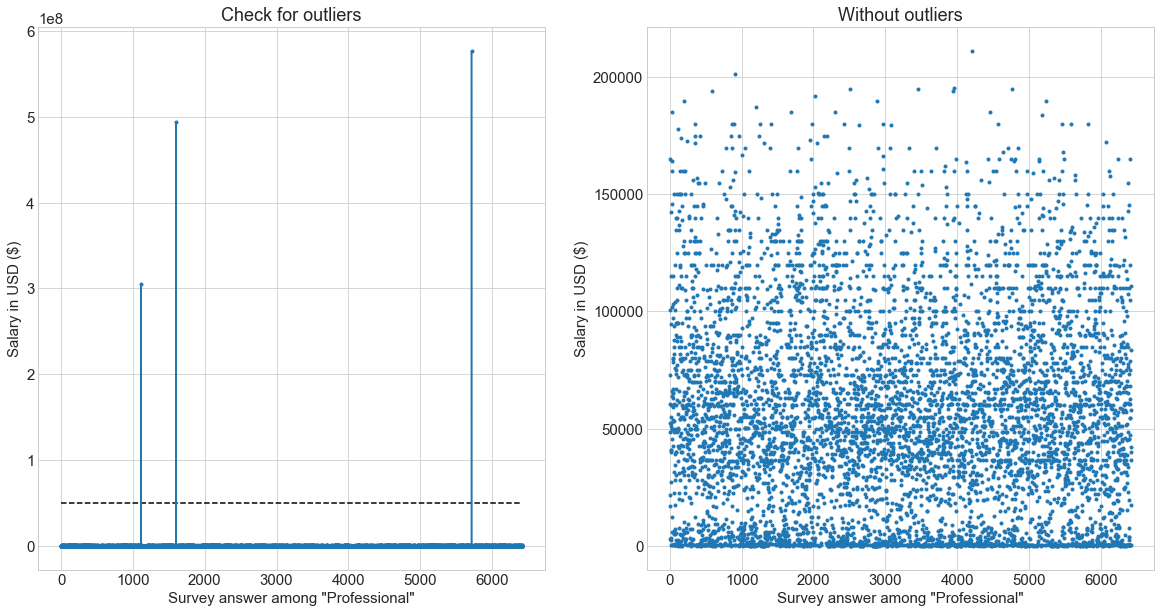

In [420]:
plt.rcParams['figure.figsize']=20, 10

thr = 0.5e8

plt.subplot(1,2,1)
df_nhires['SalaryConv_USD'].plot(style='.-', title='Check for outliers')
plt.hlines(y = thr, xmin=0, xmax=len(df_nhires), ls='dashed')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professional"')

plt.subplot(1,2,2)
df_nhires.query(f'SalaryConv_USD < {thr}')['SalaryConv_USD'].plot(style='.', title='Without outliers')
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Professional"')

> __remove outliers in salary__ with threshold over $500000 

In [64]:
df_nhires = df_nhires.query(f'SalaryConv_USD < {thr}').reset_index(drop=True)

3. Distribution of salary over all "Professional" and by category of professional

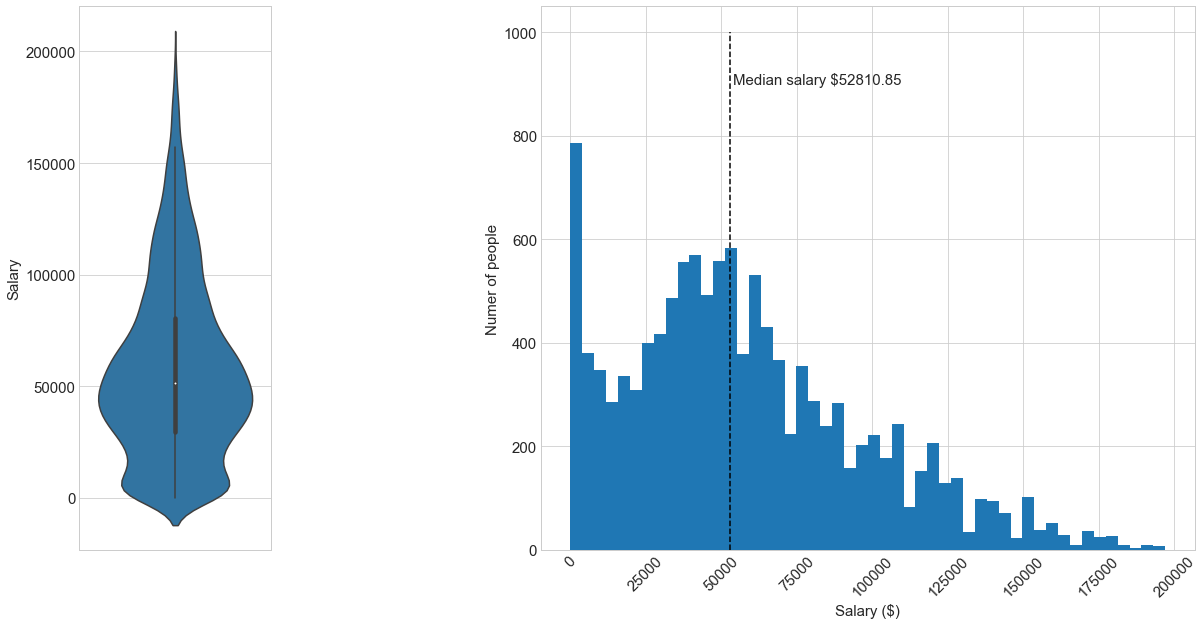

In [65]:
sal_median = df_pro['SalaryConv_USD'].median()

plt.subplot2grid((1,5),(0,2),colspan=3)
df_pro['Salary'].hist(bins=50, xrot=45)
plt.vlines(x = sal_median, ymin=0, ymax=1000, linestyles='--')
plt.text(sal_median+1000, 900, f'Median salary ${sal_median:.2f}')
plt.xlabel('Salary ($)')
plt.ylabel('Numer of people')

plt.subplot2grid((1,5),(0,0),colspan=1)
sns.violinplot(data=df_pro, y='Salary')

In [66]:
df_pro.query('SalaryConv_USD < 1000')['Country'].value_counts()

India                 792
Russian Federation    185
Poland                 72
Mexico                 67
Japan                  47
                     ... 
Nigeria                 1
Czech Republic          1
Spain                   1
Italy                   1
Ghana                   1
Name: Country, Length: 61, dtype: int64

In [224]:
print(df_sch.query('Column == "FormalEducation"')['Question'].values[0])

Which of the following best describes the highest level of formal education that you've completed?


In [225]:
print(df_sch.query('Column == "EducationTypes"')['Question'].values[0])

Outside of your formal schooling and education, which of the following have you done?


In [227]:
df_pro['FormalEducation'].value_counts(normalize=True)

Bachelor's degree                                                    0.478536
Master's degree                                                      0.248623
Some college/university study without earning a bachelor's degree    0.149179
Secondary school                                                     0.063104
Doctoral degree                                                      0.021893
Professional degree                                                  0.015029
I prefer not to answer                                               0.010766
I never completed any formal education                               0.007224
Primary/elementary school                                            0.005646
Name: FormalEducation, dtype: float64

In [32]:
dictEducType = getChoices(df_pro['EducationTypes'])

# count values for each category of 'CousinEducation' 
EdTypeCount = {k: len(v) for k, v in dictEducType.items()}

# first we reorder answers by count
EdTypeCount = dict(sorted(EdTypeCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_EdType = np.array(list(EdTypeCount.values()))/len(df_pro) # compute percentage over all participants
EdTypeCount

{'Self-taught': 20415,
 'On-the-job training': 10434,
 'Online course': 9873,
 'Open source contributions': 8720,
 'Hackathon': 5681,
 'Coding competition': 4884,
 'Industry certification': 3672,
 'Part-time/evening course': 3364,
 'Bootcamp': 2107}

(0.0, 60)

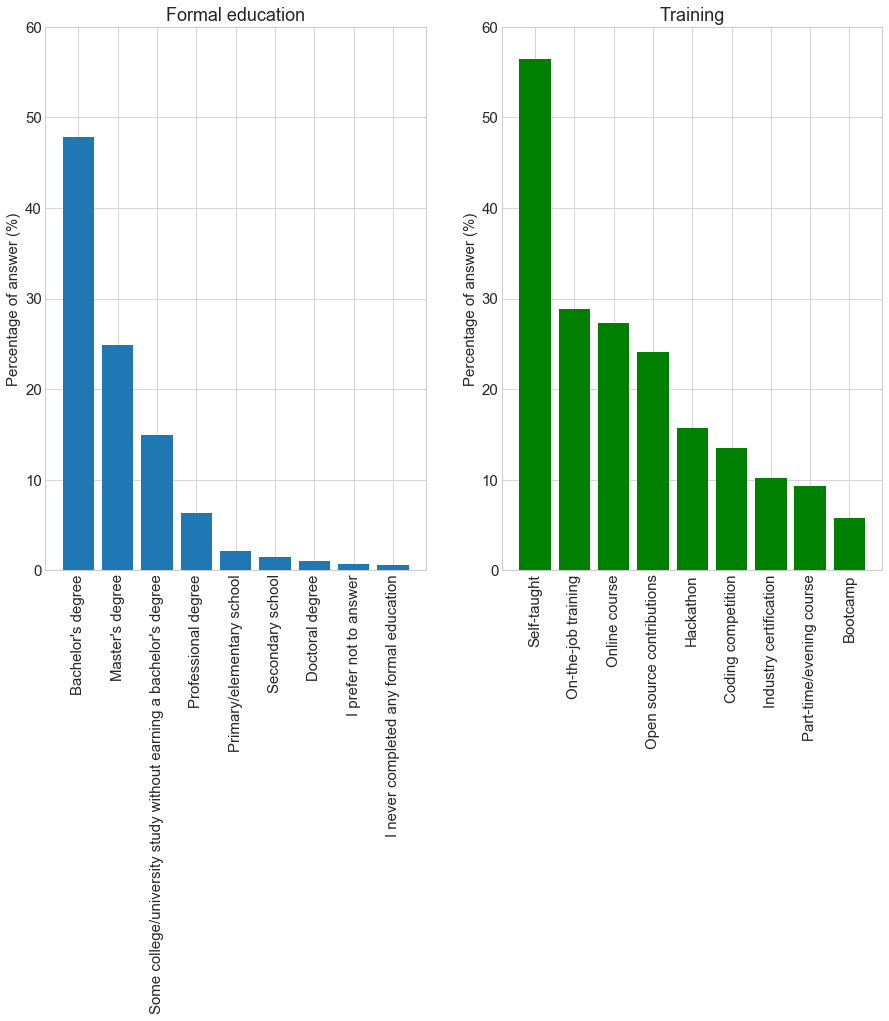

In [230]:
plt.rcParams['figure.figsize']= 15,10

plt.subplot(1,2,1)
plt.bar(
    x = df_pro['FormalEducation'].unique(),
    height = df_pro['FormalEducation'].value_counts(normalize=True)*100
)
plt.xticks(rotation=90)
plt.ylabel('Percentage of answer (%)')
plt.title("Formal education")
plt.ylim(top=60)

plt.subplot(1,2,2)
plt.bar(list(EdTypeCount.keys()), perc_EdType*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title("Training")
plt.ylim(top=60)

[Text(0, 0, '0%'), Text(0, 0, '5%'), Text(0, 0, '10%'), Text(0, 0, '15%')]

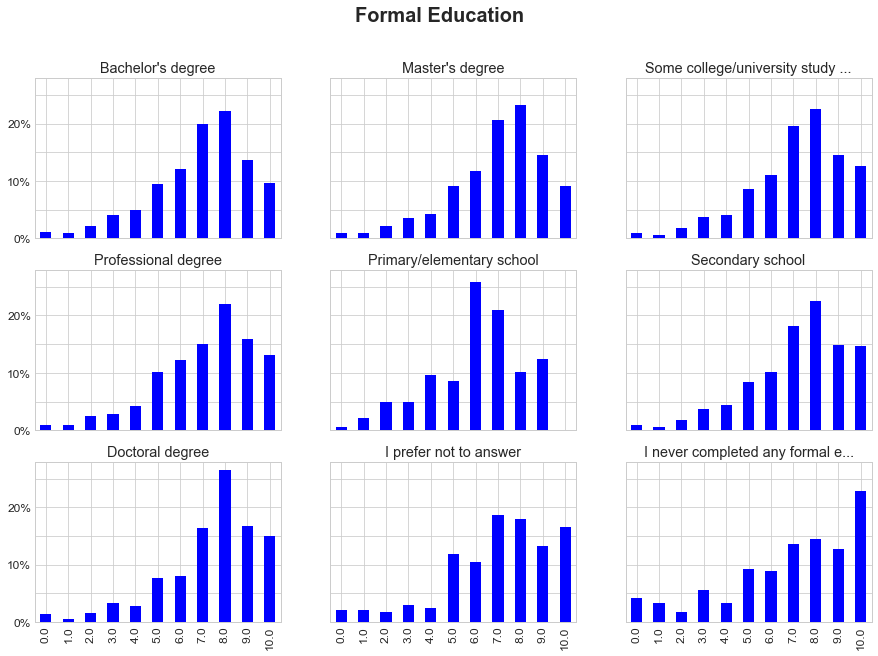

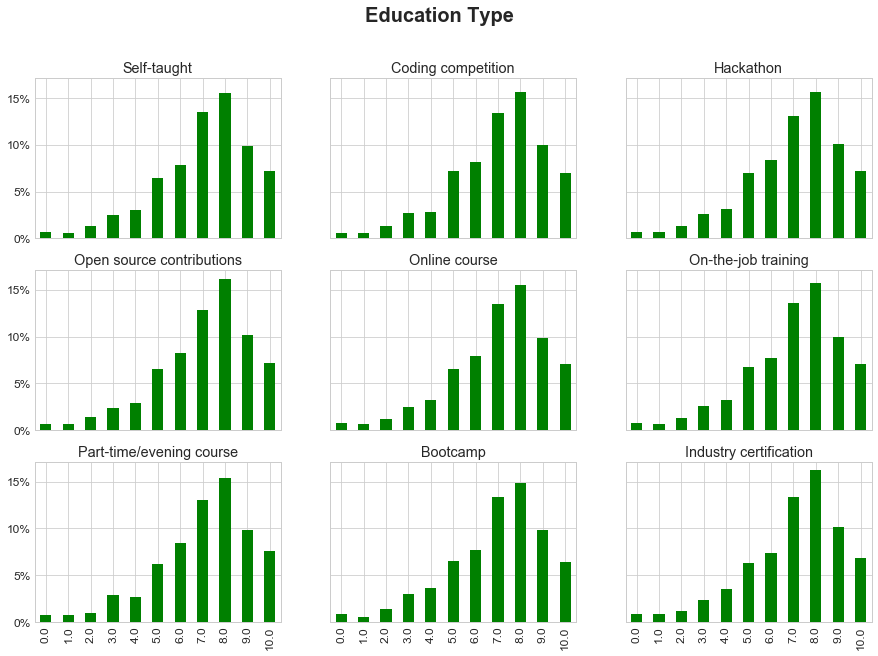

In [163]:
f1, ax1 = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
f1.suptitle('Formal Education', fontweight=900, fontsize=20)
win1=0
for ed in df_pro['FormalEducation'].unique():
    if len(ed) > 30:
        title_ed = ed[:30]+'...'
    else:
        title_ed = ed
        
    win1 += 1
    data1 = df_pro.query(f'FormalEducation == "{ed}"')['JobSatisfaction'].value_counts(normalize=True)*100
    data1.sort_index().plot(kind='bar', ax=ax1.ravel()[win1-1], title=title_ed, color='b')

ax1.ravel()[0].axes.set_yticklabels(['0%', '', '10%', '', '20%'])

f2, ax2 = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
f2.suptitle('Education Type', fontweight=900, fontsize=20)
win2=0
for tr, idx  in dictEducType.items():
    win2 += 1
    data2 = df_pro['JobSatisfaction'].reindex(idx).value_counts()/len(idx)*100
    data2.sort_index().plot(kind='bar', ax=ax2.ravel()[win2-1], title=tr, color='g')

ax2.ravel()[0].axes.set_yticklabels(['0%', '5%', '10%', '15%'])

In [144]:
toto = ax1.ravel()[0].axes.xtickslabel

AttributeError: 'AxesSubplot' object has no attribute 'xtickslabel'

## What kind of Developer type are these professional?

In [69]:
dictIdx_Dev = getChoices(df_pro['DeveloperType'])
list(dictIdx_Dev.keys())

['Other',
 'Embedded applications/devices developer',
 'Web developer',
 'DevOps specialist',
 'Quality assurance engineer',
 'Mobile developer',
 'Desktop applications developer',
 'Graphics programming',
 'Developer with a statistics or mathematics background',
 'Systems administrator',
 'Data scientist',
 'Graphic designer',
 'Database administrator',
 'Machine learning specialist']

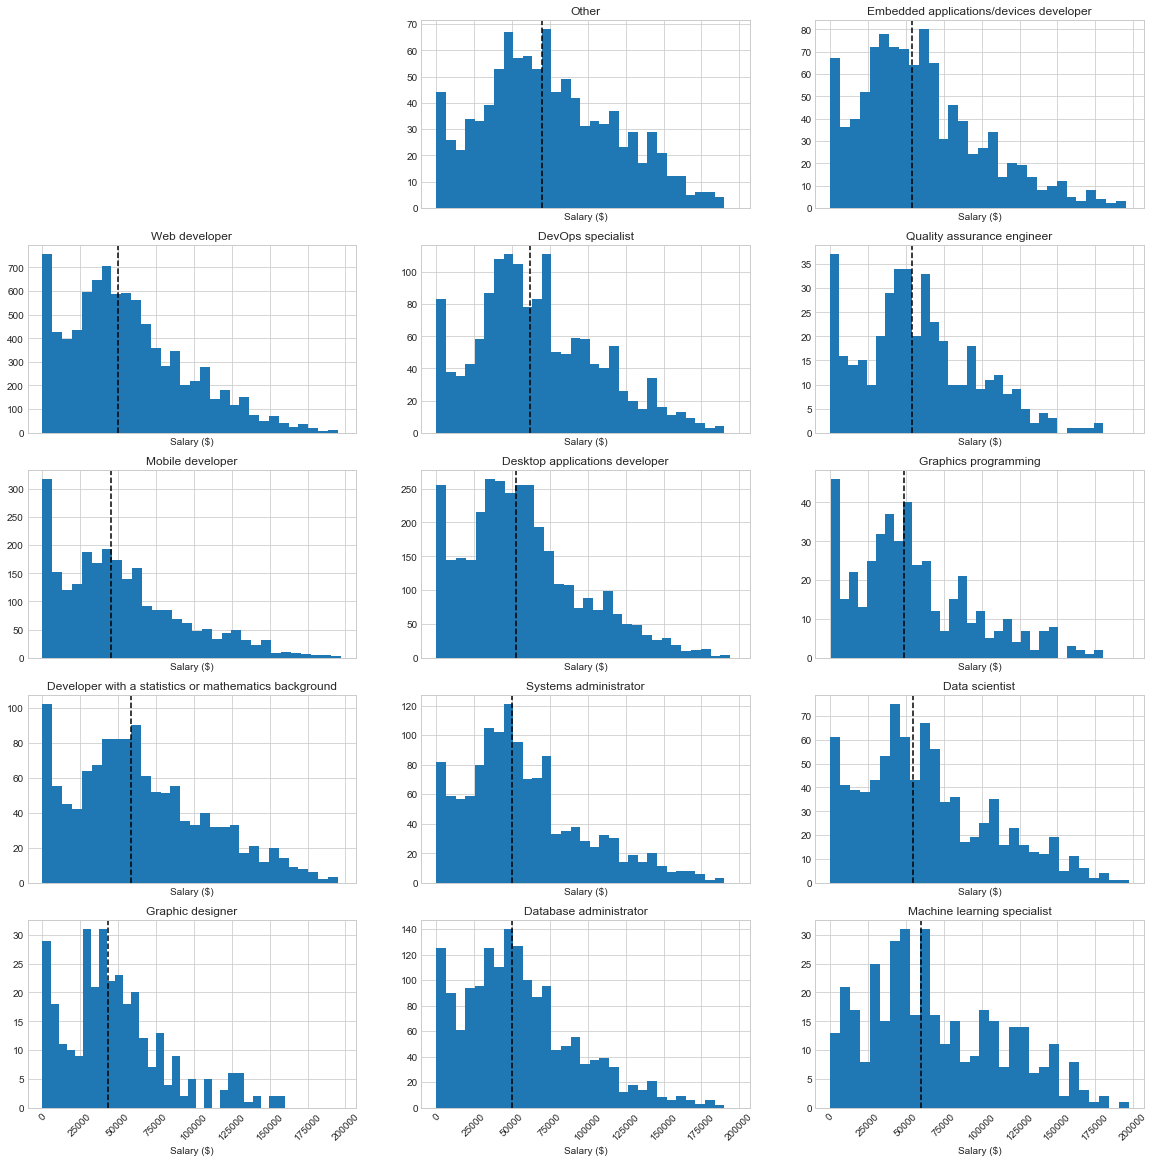

In [70]:
plt.rcParams['figure.figsize']= 20, 20
plt.rcParams['font.size']=10

f, axs = plt.subplots(5, 3, sharex=True)
for win, devtype in enumerate(dictIdx_Dev.keys()):
    idx = dictIdx_Dev[devtype]
    data = df_pro.reindex(idx)['Salary']
    med_sal = data.median()
    axis = axs.ravel()[win+1]
    data.hist(bins=30, xrot=45, ax = axis, density=False)
    axis.axvline(x=med_sal, linestyle='dashed', color='k')
    axis.set_title(devtype)
    axis.set_xlabel('Salary ($)')

f.delaxes(axs.ravel()[0])

___


In [86]:
sal_per_Adv = {k: df_pro['SalaryConv_USD'] for k, v in dictEducAdv.items()}
med_sal_per_Adv = {k: df_pro['SalaryConv_USD'].reindex(v).median() for k, v in dictEducAdv.items()}
std_sal_per_Adv = {k: df_pro['SalaryConv_USD'].reindex(v).std() for k, v in dictEducAdv.items()}
std_sal_per_Adv

{'Get a job as a QA tester': 43420.00922245089,
 'Conferences/meet-ups': 43431.71249463859,
 'Take online courses': 42854.08582494905,
 'Participate in online coding competitions': 41509.02041837788,
 'Buy books and work through the exercises': 43191.07770724858,
 'None of these': 41956.85538917023,
 'Bootcamp': 44611.0043785985,
 'Part-time/evening courses': 42207.51559099282,
 'Contribute to open source': 44117.7361026396,
 'Participate in hackathons': 44570.511576835044,
 'Other': 41026.06884385914,
 'Return to college': 40077.205476382456,
 "Master's degree": 44458.38048642209}

In [87]:
med_sal_per_Adv

{'Get a job as a QA tester': 53445.8260752229,
 'Conferences/meet-ups': 54364.106374375,
 'Take online courses': 50000.0,
 'Participate in online coding competitions': 41080.697413156246,
 'Buy books and work through the exercises': 52810.84619225,
 'None of these': 44133.4265532564,
 'Bootcamp': 54364.106374375,
 'Part-time/evening courses': 48303.9392751486,
 'Contribute to open source': 57806.560000000005,
 'Participate in hackathons': 54364.106374375,
 'Other': 57185.8096891796,
 'Return to college': 54364.106374375,
 "Master's degree": 57806.560000000005}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

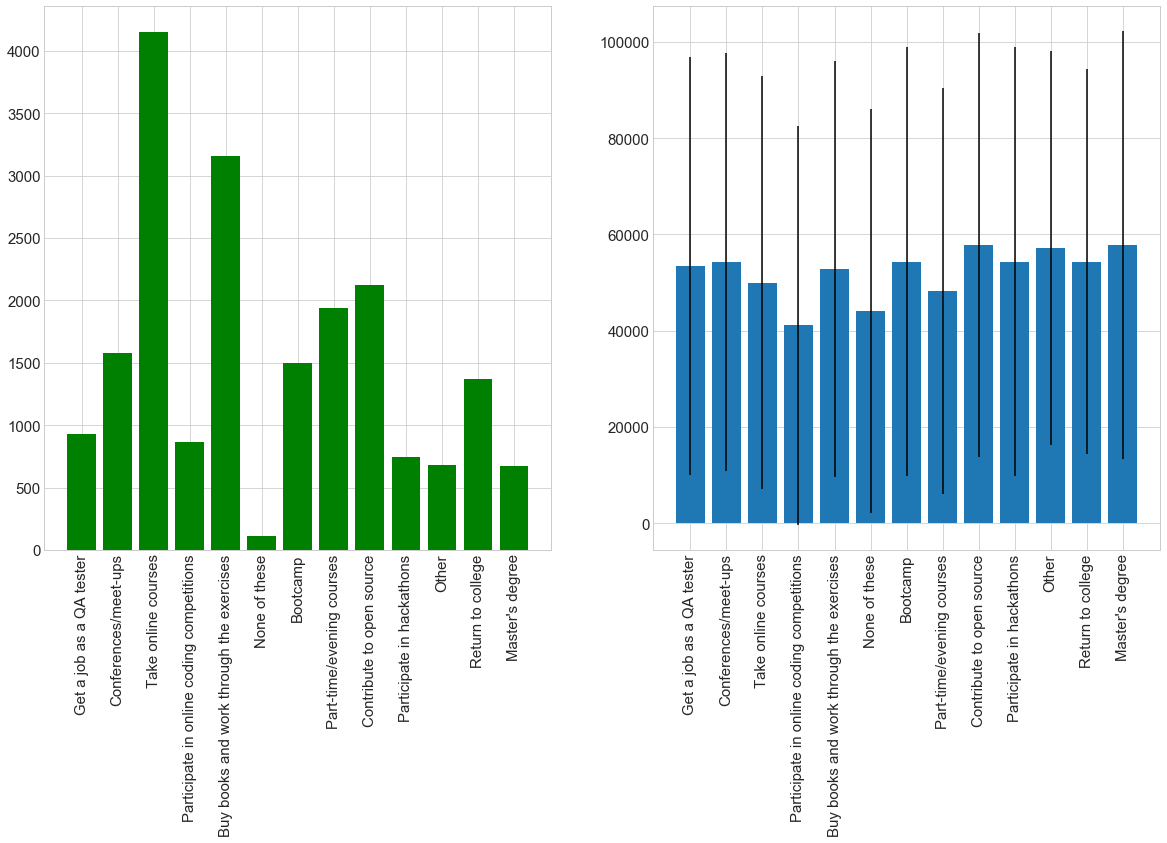

In [91]:
plt.rcParams['figure.figsize']=20, 10
plt.rcParams['font.size']=15

plt.subplot(1,2,1)
plt.bar(list(AdvCount.keys()), AdvCount.values(), color='g')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.bar(list(AdvCount.keys()),  med_sal_per_Adv.values(), yerr = std_sal_per_Adv.values())
plt.xticks(rotation=90)